In [2]:
pd.__version__

'2.3.2'

In [1]:
!pip install pyarrow

In [2]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import xgboost as xgb
import mlflow

/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-2")

2025/09/26 19:53:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/26 19:53:20 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/09/26 19:53:20 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1758916400694, experiment_id='2', last_update_time=1758916400694, lifecycle_stage='active', name='nyc-taxi-experiment-2', tags={}>

In [21]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [23]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [24]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")

In [25]:
df[
    df.trip_type == 2
].count()

VendorID                 1238
lpep_pickup_datetime     1238
lpep_dropoff_datetime    1238
store_and_fwd_flag       1238
RatecodeID               1238
PULocationID             1238
DOLocationID             1238
passenger_count          1238
trip_distance            1238
fare_amount              1238
extra                    1238
mta_tax                  1238
tip_amount               1238
tolls_amount             1238
ehail_fee                   0
improvement_surcharge    1238
total_amount             1238
payment_type             1238
trip_type                1238
congestion_surcharge     1238
dtype: int64

In [26]:
df.lpep_dropoff_datetime.describe()

count                         76518
mean     2021-01-16 16:12:17.846781
min             2009-01-01 00:12:25
25%             2021-01-08 23:42:32
50%      2021-01-16 10:30:42.500000
75%             2021-01-24 09:55:45
max             2021-02-01 16:56:37
Name: lpep_dropoff_datetime, dtype: object

In [27]:
# df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
# df.lpep_pickup_datetime  = pd.to_datetime(df.lpep_pickup_datetime)

In [28]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [29]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [30]:
td = df.duration.iloc[0]

In [31]:
td.total_seconds() / 60

AttributeError: 'numpy.float64' object has no attribute 'total_seconds'

In [ ]:
sns.displot(df.duration)

In [ ]:
df.duration.describe()

In [ ]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

In [ ]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [32]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [33]:
df[categorical] = df[categorical].astype(str)

In [34]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [35]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [36]:
train_dicts

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '225', 'trip_distance': 0.0},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48},
 {'PU

In [37]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [38]:
X_train

<76518x508 sparse matrix of type '<class 'numpy.float64'>'
	with 229554 stored elements in Compressed Sparse Row format>

In [39]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [40]:
target = 'duration'
y_train = df[target].values

In [41]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

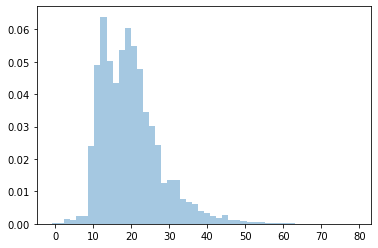

In [44]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [ ]:
mean_squared_error(y_train, y_pred, squared=False) # error about 9.7 munites, our baseline

In [ ]:
# here is start

In [45]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    df[categorical] = df[categorical].astype(str)
    
    return df

In [46]:
path_to_file_jan = "data/green_tripdata_2021-01.parquet"
path_to_file_feb = "data/green_tripdata_2021-02.parquet"

df_train = read_dataframe(path_to_file_jan)
df_val = read_dataframe(path_to_file_feb)

In [47]:
len(df_train), len (df_val)

(73908, 61921)

In [48]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [49]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [50]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479569957943581

In [12]:
with mlflow.start_run():    
    mlflow.set_tag("musician", "roman")
    
    mlflow.log_param("train-data-path", path_to_file_jan)
    mlflow.log_param("valid-data-path", path_to_file_jan)
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

MlflowException: Could not find experiment with ID 0

In [ ]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

In [118]:
os.mkdir('models', exist_ok=True)
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/bin/bash: line 1: md: command not found


In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

NameError: name 'X_train' is not defined

In [18]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:40:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.44625                                                                                                                     
[1]	validation-rmse:7.19823                                                                                                                     
[2]	validation-rmse:6.81276                                                                                                                     
[3]	validation-rmse:6.68427                                                                                                                     
[4]	validation-rmse:6.62915                                                                                                                     
[5]	validation-rmse:6.60541                                                                                                                     
[6]	validation-rmse:6.59239                                                                                                       

[56]	validation-rmse:6.44791                                                                                                                    
[57]	validation-rmse:6.44330                                                                                                                    
[58]	validation-rmse:6.44091                                                                                                                    
[59]	validation-rmse:6.43987                                                                                                                    
[60]	validation-rmse:6.43766                                                                                                                    
[61]	validation-rmse:6.43666                                                                                                                    
[62]	validation-rmse:6.43580                                                                                                      

[112]	validation-rmse:6.38785                                                                                                                   
[113]	validation-rmse:6.38772                                                                                                                   
[114]	validation-rmse:6.38717                                                                                                                   
[115]	validation-rmse:6.38730                                                                                                                   
[116]	validation-rmse:6.38604                                                                                                                   
[117]	validation-rmse:6.38581                                                                                                                   
[118]	validation-rmse:6.38486                                                                                                     

[168]	validation-rmse:6.35463                                                                                                                   
[169]	validation-rmse:6.35502                                                                                                                   
[170]	validation-rmse:6.35442                                                                                                                   
[171]	validation-rmse:6.35400                                                                                                                   
[172]	validation-rmse:6.35403                                                                                                                   
[173]	validation-rmse:6.35328                                                                                                                   
[174]	validation-rmse:6.35290                                                                                                     

[224]	validation-rmse:6.33539                                                                                                                   
[225]	validation-rmse:6.33516                                                                                                                   
[226]	validation-rmse:6.33478                                                                                                                   
[227]	validation-rmse:6.33405                                                                                                                   
[228]	validation-rmse:6.33419                                                                                                                   
[229]	validation-rmse:6.33349                                                                                                                   
[230]	validation-rmse:6.33279                                                                                                     

[280]	validation-rmse:6.32845                                                                                                                   
[281]	validation-rmse:6.32837                                                                                                                   
[282]	validation-rmse:6.32908                                                                                                                   
[283]	validation-rmse:6.32683                                                                                                                   
[284]	validation-rmse:6.32679                                                                                                                   
[285]	validation-rmse:6.32675                                                                                                                   
[286]	validation-rmse:6.32683                                                                                                     

[336]	validation-rmse:6.32828                                                                                                                   
[337]	validation-rmse:6.32826                                                                                                                   
[338]	validation-rmse:6.32791                                                                                                                   
[339]	validation-rmse:6.32830                                                                                                                   
[340]	validation-rmse:6.32807                                                                                                                   
[341]	validation-rmse:6.32778                                                                                                                   
[342]	validation-rmse:6.32791                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:41:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84244                                                                                                                     
[1]	validation-rmse:7.49433                                                                                                                     
[2]	validation-rmse:6.99415                                                                                                                     
[3]	validation-rmse:6.80174                                                                                                                     
[4]	validation-rmse:6.72166                                                                                                                     
[5]	validation-rmse:6.68223                                                                                                                     
[6]	validation-rmse:6.66275                                                                                                       

[56]	validation-rmse:6.54551                                                                                                                    
[57]	validation-rmse:6.54392                                                                                                                    
[58]	validation-rmse:6.54379                                                                                                                    
[59]	validation-rmse:6.54314                                                                                                                    
[60]	validation-rmse:6.54258                                                                                                                    
[61]	validation-rmse:6.54189                                                                                                                    
[62]	validation-rmse:6.54091                                                                                                      

[112]	validation-rmse:6.49920                                                                                                                   
[113]	validation-rmse:6.49887                                                                                                                   
[114]	validation-rmse:6.49836                                                                                                                   
[115]	validation-rmse:6.49796                                                                                                                   
[116]	validation-rmse:6.49760                                                                                                                   
[117]	validation-rmse:6.49724                                                                                                                   
[118]	validation-rmse:6.49718                                                                                                     

[168]	validation-rmse:6.48179                                                                                                                   
[169]	validation-rmse:6.48152                                                                                                                   
[170]	validation-rmse:6.48128                                                                                                                   
[171]	validation-rmse:6.48102                                                                                                                   
[172]	validation-rmse:6.48062                                                                                                                   
[173]	validation-rmse:6.48047                                                                                                                   
[174]	validation-rmse:6.48059                                                                                                     

[224]	validation-rmse:6.47252                                                                                                                   
[225]	validation-rmse:6.47235                                                                                                                   
[226]	validation-rmse:6.47249                                                                                                                   
[227]	validation-rmse:6.47193                                                                                                                   
[228]	validation-rmse:6.47148                                                                                                                   
[229]	validation-rmse:6.47112                                                                                                                   
[230]	validation-rmse:6.47062                                                                                                     

[280]	validation-rmse:6.46438                                                                                                                   
[281]	validation-rmse:6.46440                                                                                                                   
[282]	validation-rmse:6.46420                                                                                                                   
[283]	validation-rmse:6.46404                                                                                                                   
[284]	validation-rmse:6.46412                                                                                                                   
[285]	validation-rmse:6.46383                                                                                                                   
[286]	validation-rmse:6.46334                                                                                                     

[336]	validation-rmse:6.46003                                                                                                                   
[337]	validation-rmse:6.46021                                                                                                                   
[338]	validation-rmse:6.45999                                                                                                                   
[339]	validation-rmse:6.46039                                                                                                                   
[340]	validation-rmse:6.46013                                                                                                                   
[341]	validation-rmse:6.46016                                                                                                                   
[342]	validation-rmse:6.46006                                                                                                     

[392]	validation-rmse:6.45810                                                                                                                   
[393]	validation-rmse:6.45802                                                                                                                   
[394]	validation-rmse:6.45804                                                                                                                   
[395]	validation-rmse:6.45798                                                                                                                   
[396]	validation-rmse:6.45791                                                                                                                   
[397]	validation-rmse:6.45794                                                                                                                   
[398]	validation-rmse:6.45798                                                                                                     

[448]	validation-rmse:6.45494                                                                                                                   
[449]	validation-rmse:6.45487                                                                                                                   
[450]	validation-rmse:6.45487                                                                                                                   
[451]	validation-rmse:6.45503                                                                                                                   
[452]	validation-rmse:6.45498                                                                                                                   
[453]	validation-rmse:6.45462                                                                                                                   
[454]	validation-rmse:6.45453                                                                                                     

[504]	validation-rmse:6.45346                                                                                                                   
[505]	validation-rmse:6.45336                                                                                                                   
[506]	validation-rmse:6.45341                                                                                                                   
[507]	validation-rmse:6.45312                                                                                                                   
[508]	validation-rmse:6.45314                                                                                                                   
[509]	validation-rmse:6.45324                                                                                                                   
[510]	validation-rmse:6.45321                                                                                                     

[560]	validation-rmse:6.45385                                                                                                                   
[561]	validation-rmse:6.45390                                                                                                                   
[562]	validation-rmse:6.45382                                                                                                                   
[563]	validation-rmse:6.45371                                                                                                                   
[564]	validation-rmse:6.45362                                                                                                                   
[565]	validation-rmse:6.45357                                                                                                                   
[566]	validation-rmse:6.45369                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:42:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80593                                                                                                                    
[1]	validation-rmse:11.42519                                                                                                                    
[2]	validation-rmse:11.06951                                                                                                                    
[3]	validation-rmse:10.73732                                                                                                                    
[4]	validation-rmse:10.42750                                                                                                                    
[5]	validation-rmse:10.13838                                                                                                                    
[6]	validation-rmse:9.86924                                                                                                       

[56]	validation-rmse:6.61044                                                                                                                    
[57]	validation-rmse:6.60487                                                                                                                    
[58]	validation-rmse:6.59943                                                                                                                    
[59]	validation-rmse:6.59470                                                                                                                    
[60]	validation-rmse:6.58874                                                                                                                    
[61]	validation-rmse:6.58438                                                                                                                    
[62]	validation-rmse:6.57990                                                                                                      

[112]	validation-rmse:6.48552                                                                                                                   
[113]	validation-rmse:6.48486                                                                                                                   
[114]	validation-rmse:6.48431                                                                                                                   
[115]	validation-rmse:6.48373                                                                                                                   
[116]	validation-rmse:6.48342                                                                                                                   
[117]	validation-rmse:6.48262                                                                                                                   
[118]	validation-rmse:6.48230                                                                                                     

[168]	validation-rmse:6.46533                                                                                                                   
[169]	validation-rmse:6.46512                                                                                                                   
[170]	validation-rmse:6.46489                                                                                                                   
[171]	validation-rmse:6.46477                                                                                                                   
[172]	validation-rmse:6.46459                                                                                                                   
[173]	validation-rmse:6.46446                                                                                                                   
[174]	validation-rmse:6.46427                                                                                                     

[224]	validation-rmse:6.45639                                                                                                                   
[225]	validation-rmse:6.45630                                                                                                                   
[226]	validation-rmse:6.45625                                                                                                                   
[227]	validation-rmse:6.45615                                                                                                                   
[228]	validation-rmse:6.45595                                                                                                                   
[229]	validation-rmse:6.45583                                                                                                                   
[230]	validation-rmse:6.45573                                                                                                     

[280]	validation-rmse:6.45034                                                                                                                   
[281]	validation-rmse:6.45033                                                                                                                   
[282]	validation-rmse:6.45027                                                                                                                   
[283]	validation-rmse:6.45011                                                                                                                   
[284]	validation-rmse:6.45001                                                                                                                   
[285]	validation-rmse:6.44986                                                                                                                   
[286]	validation-rmse:6.44980                                                                                                     

[336]	validation-rmse:6.44593                                                                                                                   
[337]	validation-rmse:6.44586                                                                                                                   
[338]	validation-rmse:6.44578                                                                                                                   
[339]	validation-rmse:6.44575                                                                                                                   
[340]	validation-rmse:6.44567                                                                                                                   
[341]	validation-rmse:6.44563                                                                                                                   
[342]	validation-rmse:6.44555                                                                                                     

[392]	validation-rmse:6.44285                                                                                                                   
[393]	validation-rmse:6.44281                                                                                                                   
[394]	validation-rmse:6.44276                                                                                                                   
[395]	validation-rmse:6.44267                                                                                                                   
[396]	validation-rmse:6.44262                                                                                                                   
[397]	validation-rmse:6.44256                                                                                                                   
[398]	validation-rmse:6.44250                                                                                                     

[448]	validation-rmse:6.44022                                                                                                                   
[449]	validation-rmse:6.44015                                                                                                                   
[450]	validation-rmse:6.44012                                                                                                                   
[451]	validation-rmse:6.44016                                                                                                                   
[452]	validation-rmse:6.44015                                                                                                                   
[453]	validation-rmse:6.44017                                                                                                                   
[454]	validation-rmse:6.44017                                                                                                     

[504]	validation-rmse:6.43776                                                                                                                   
[505]	validation-rmse:6.43777                                                                                                                   
[506]	validation-rmse:6.43781                                                                                                                   
[507]	validation-rmse:6.43772                                                                                                                   
[508]	validation-rmse:6.43768                                                                                                                   
[509]	validation-rmse:6.43769                                                                                                                   
[510]	validation-rmse:6.43770                                                                                                     

[560]	validation-rmse:6.43617                                                                                                                   
[561]	validation-rmse:6.43614                                                                                                                   
[562]	validation-rmse:6.43612                                                                                                                   
[563]	validation-rmse:6.43604                                                                                                                   
[564]	validation-rmse:6.43605                                                                                                                   
[565]	validation-rmse:6.43602                                                                                                                   
[566]	validation-rmse:6.43587                                                                                                     

[616]	validation-rmse:6.43454                                                                                                                   
[617]	validation-rmse:6.43440                                                                                                                   
[618]	validation-rmse:6.43434                                                                                                                   
[619]	validation-rmse:6.43430                                                                                                                   
[620]	validation-rmse:6.43432                                                                                                                   
[621]	validation-rmse:6.43432                                                                                                                   
[622]	validation-rmse:6.43432                                                                                                     

[672]	validation-rmse:6.43282                                                                                                                   
[673]	validation-rmse:6.43283                                                                                                                   
[674]	validation-rmse:6.43282                                                                                                                   
[675]	validation-rmse:6.43278                                                                                                                   
[676]	validation-rmse:6.43273                                                                                                                   
[677]	validation-rmse:6.43274                                                                                                                   
[678]	validation-rmse:6.43274                                                                                                     

[728]	validation-rmse:6.43214                                                                                                                   
[729]	validation-rmse:6.43206                                                                                                                   
[730]	validation-rmse:6.43196                                                                                                                   
[731]	validation-rmse:6.43201                                                                                                                   
[732]	validation-rmse:6.43198                                                                                                                   
[733]	validation-rmse:6.43196                                                                                                                   
[734]	validation-rmse:6.43194                                                                                                     

[784]	validation-rmse:6.43202                                                                                                                   
[785]	validation-rmse:6.43197                                                                                                                   
[786]	validation-rmse:6.43198                                                                                                                   
[787]	validation-rmse:6.43200                                                                                                                   
[788]	validation-rmse:6.43204                                                                                                                   
[789]	validation-rmse:6.43202                                                                                                                   
[790]	validation-rmse:6.43200                                                                                                     

[840]	validation-rmse:6.43153                                                                                                                   
[841]	validation-rmse:6.43152                                                                                                                   
[842]	validation-rmse:6.43152                                                                                                                   
[843]	validation-rmse:6.43152                                                                                                                   
[844]	validation-rmse:6.43151                                                                                                                   
[845]	validation-rmse:6.43148                                                                                                                   
[846]	validation-rmse:6.43143                                                                                                     

[896]	validation-rmse:6.43063                                                                                                                   
[897]	validation-rmse:6.43060                                                                                                                   
[898]	validation-rmse:6.43061                                                                                                                   
[899]	validation-rmse:6.43068                                                                                                                   
[900]	validation-rmse:6.43067                                                                                                                   
[901]	validation-rmse:6.43062                                                                                                                   
[902]	validation-rmse:6.43065                                                                                                     

[952]	validation-rmse:6.43006                                                                                                                   
[953]	validation-rmse:6.43004                                                                                                                   
[954]	validation-rmse:6.43002                                                                                                                   
[955]	validation-rmse:6.43004                                                                                                                   
[956]	validation-rmse:6.43002                                                                                                                   
[957]	validation-rmse:6.42998                                                                                                                   
[958]	validation-rmse:6.42997                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:50:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.55054                                                                                                                    
[1]	validation-rmse:9.35225                                                                                                                     
[2]	validation-rmse:8.50487                                                                                                                     
[3]	validation-rmse:7.91599                                                                                                                     
[4]	validation-rmse:7.51552                                                                                                                     
[5]	validation-rmse:7.24025                                                                                                                     
[6]	validation-rmse:7.05129                                                                                                       

[56]	validation-rmse:6.54085                                                                                                                    
[57]	validation-rmse:6.54039                                                                                                                    
[58]	validation-rmse:6.53989                                                                                                                    
[59]	validation-rmse:6.53934                                                                                                                    
[60]	validation-rmse:6.53861                                                                                                                    
[61]	validation-rmse:6.53808                                                                                                                    
[62]	validation-rmse:6.53738                                                                                                      

[112]	validation-rmse:6.50976                                                                                                                   
[113]	validation-rmse:6.50943                                                                                                                   
[114]	validation-rmse:6.50911                                                                                                                   
[115]	validation-rmse:6.50862                                                                                                                   
[116]	validation-rmse:6.50829                                                                                                                   
[117]	validation-rmse:6.50805                                                                                                                   
[118]	validation-rmse:6.50788                                                                                                     

[168]	validation-rmse:6.49606                                                                                                                   
[169]	validation-rmse:6.49589                                                                                                                   
[170]	validation-rmse:6.49595                                                                                                                   
[171]	validation-rmse:6.49593                                                                                                                   
[172]	validation-rmse:6.49583                                                                                                                   
[173]	validation-rmse:6.49581                                                                                                                   
[174]	validation-rmse:6.49567                                                                                                     

[224]	validation-rmse:6.49055                                                                                                                   
[225]	validation-rmse:6.49051                                                                                                                   
[226]	validation-rmse:6.49054                                                                                                                   
[227]	validation-rmse:6.49018                                                                                                                   
[228]	validation-rmse:6.49017                                                                                                                   
[229]	validation-rmse:6.48997                                                                                                                   
[230]	validation-rmse:6.48982                                                                                                     

[280]	validation-rmse:6.48467                                                                                                                   
[281]	validation-rmse:6.48458                                                                                                                   
[282]	validation-rmse:6.48470                                                                                                                   
[283]	validation-rmse:6.48464                                                                                                                   
[284]	validation-rmse:6.48448                                                                                                                   
[285]	validation-rmse:6.48426                                                                                                                   
[286]	validation-rmse:6.48417                                                                                                     

[336]	validation-rmse:6.47980                                                                                                                   
[337]	validation-rmse:6.47975                                                                                                                   
[338]	validation-rmse:6.47979                                                                                                                   
[339]	validation-rmse:6.47974                                                                                                                   
[340]	validation-rmse:6.47963                                                                                                                   
[341]	validation-rmse:6.47947                                                                                                                   
[342]	validation-rmse:6.47963                                                                                                     

[392]	validation-rmse:6.47691                                                                                                                   
[393]	validation-rmse:6.47684                                                                                                                   
[394]	validation-rmse:6.47694                                                                                                                   
[395]	validation-rmse:6.47693                                                                                                                   
[396]	validation-rmse:6.47684                                                                                                                   
[397]	validation-rmse:6.47675                                                                                                                   
[398]	validation-rmse:6.47660                                                                                                     

[448]	validation-rmse:6.47297                                                                                                                   
[449]	validation-rmse:6.47270                                                                                                                   
[450]	validation-rmse:6.47265                                                                                                                   
[451]	validation-rmse:6.47261                                                                                                                   
[452]	validation-rmse:6.47263                                                                                                                   
[453]	validation-rmse:6.47259                                                                                                                   
[454]	validation-rmse:6.47259                                                                                                     

[504]	validation-rmse:6.46979                                                                                                                   
[505]	validation-rmse:6.46993                                                                                                                   
[506]	validation-rmse:6.47000                                                                                                                   
[507]	validation-rmse:6.47002                                                                                                                   
[508]	validation-rmse:6.47010                                                                                                                   
[509]	validation-rmse:6.47015                                                                                                                   
[510]	validation-rmse:6.47009                                                                                                     

[560]	validation-rmse:6.46867                                                                                                                   
[561]	validation-rmse:6.46870                                                                                                                   
[562]	validation-rmse:6.46864                                                                                                                   
[563]	validation-rmse:6.46860                                                                                                                   
[564]	validation-rmse:6.46850                                                                                                                   
[565]	validation-rmse:6.46840                                                                                                                   
[566]	validation-rmse:6.46832                                                                                                     

[616]	validation-rmse:6.46684                                                                                                                   
[617]	validation-rmse:6.46686                                                                                                                   
[618]	validation-rmse:6.46691                                                                                                                   
[619]	validation-rmse:6.46689                                                                                                                   
[620]	validation-rmse:6.46689                                                                                                                   
[621]	validation-rmse:6.46686                                                                                                                   
[622]	validation-rmse:6.46664                                                                                                     

[672]	validation-rmse:6.46472                                                                                                                   
[673]	validation-rmse:6.46461                                                                                                                   
[674]	validation-rmse:6.46468                                                                                                                   
[675]	validation-rmse:6.46468                                                                                                                   
[676]	validation-rmse:6.46469                                                                                                                   
[677]	validation-rmse:6.46462                                                                                                                   
[678]	validation-rmse:6.46463                                                                                                     

[728]	validation-rmse:6.46292                                                                                                                   
[729]	validation-rmse:6.46306                                                                                                                   
[730]	validation-rmse:6.46294                                                                                                                   
[731]	validation-rmse:6.46286                                                                                                                   
[732]	validation-rmse:6.46284                                                                                                                   
[733]	validation-rmse:6.46292                                                                                                                   
[734]	validation-rmse:6.46293                                                                                                     

[784]	validation-rmse:6.46138                                                                                                                   
[785]	validation-rmse:6.46147                                                                                                                   
[786]	validation-rmse:6.46167                                                                                                                   
[787]	validation-rmse:6.46177                                                                                                                   
[788]	validation-rmse:6.46180                                                                                                                   
[789]	validation-rmse:6.46185                                                                                                                   
[790]	validation-rmse:6.46183                                                                                                     

[840]	validation-rmse:6.46122                                                                                                                   
[841]	validation-rmse:6.46132                                                                                                                   
[842]	validation-rmse:6.46118                                                                                                                   
[843]	validation-rmse:6.46127                                                                                                                   
[844]	validation-rmse:6.46116                                                                                                                   
[845]	validation-rmse:6.46126                                                                                                                   
[846]	validation-rmse:6.46125                                                                                                     

[896]	validation-rmse:6.46032                                                                                                                   
[897]	validation-rmse:6.46031                                                                                                                   
[898]	validation-rmse:6.46031                                                                                                                   
[899]	validation-rmse:6.46029                                                                                                                   
[900]	validation-rmse:6.46005                                                                                                                   
[901]	validation-rmse:6.46003                                                                                                                   
[902]	validation-rmse:6.45985                                                                                                     

[952]	validation-rmse:6.45972                                                                                                                   
[953]	validation-rmse:6.45973                                                                                                                   
[954]	validation-rmse:6.45976                                                                                                                   
[955]	validation-rmse:6.45956                                                                                                                   
[956]	validation-rmse:6.45964                                                                                                                   
[957]	validation-rmse:6.45968                                                                                                                   
[958]	validation-rmse:6.45966                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:52:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46924                                                                                                                    
[1]	validation-rmse:10.81653                                                                                                                    
[2]	validation-rmse:10.24585                                                                                                                    
[3]	validation-rmse:9.74870                                                                                                                     
[4]	validation-rmse:9.31707                                                                                                                     
[5]	validation-rmse:8.94379                                                                                                                     
[6]	validation-rmse:8.62207                                                                                                       

[56]	validation-rmse:6.65271                                                                                                                    
[57]	validation-rmse:6.65164                                                                                                                    
[58]	validation-rmse:6.65091                                                                                                                    
[59]	validation-rmse:6.65003                                                                                                                    
[60]	validation-rmse:6.64941                                                                                                                    
[61]	validation-rmse:6.64875                                                                                                                    
[62]	validation-rmse:6.64803                                                                                                      

[112]	validation-rmse:6.63125                                                                                                                   
[113]	validation-rmse:6.63111                                                                                                                   
[114]	validation-rmse:6.63100                                                                                                                   
[115]	validation-rmse:6.63089                                                                                                                   
[116]	validation-rmse:6.63087                                                                                                                   
[117]	validation-rmse:6.63066                                                                                                                   
[118]	validation-rmse:6.63051                                                                                                     

[168]	validation-rmse:6.62469                                                                                                                   
[169]	validation-rmse:6.62434                                                                                                                   
[170]	validation-rmse:6.62430                                                                                                                   
[171]	validation-rmse:6.62426                                                                                                                   
[172]	validation-rmse:6.62415                                                                                                                   
[173]	validation-rmse:6.62401                                                                                                                   
[174]	validation-rmse:6.62395                                                                                                     

[224]	validation-rmse:6.62027                                                                                                                   
[225]	validation-rmse:6.62031                                                                                                                   
[226]	validation-rmse:6.62008                                                                                                                   
[227]	validation-rmse:6.62010                                                                                                                   
[228]	validation-rmse:6.62006                                                                                                                   
[229]	validation-rmse:6.61998                                                                                                                   
[230]	validation-rmse:6.62000                                                                                                     

[280]	validation-rmse:6.61714                                                                                                                   
[281]	validation-rmse:6.61708                                                                                                                   
[282]	validation-rmse:6.61707                                                                                                                   
[283]	validation-rmse:6.61703                                                                                                                   
[284]	validation-rmse:6.61681                                                                                                                   
[285]	validation-rmse:6.61679                                                                                                                   
[286]	validation-rmse:6.61671                                                                                                     

[336]	validation-rmse:6.61405                                                                                                                   
[337]	validation-rmse:6.61407                                                                                                                   
[338]	validation-rmse:6.61396                                                                                                                   
[339]	validation-rmse:6.61389                                                                                                                   
[340]	validation-rmse:6.61392                                                                                                                   
[341]	validation-rmse:6.61386                                                                                                                   
[342]	validation-rmse:6.61386                                                                                                     

[392]	validation-rmse:6.61163                                                                                                                   
[393]	validation-rmse:6.61161                                                                                                                   
[394]	validation-rmse:6.61153                                                                                                                   
[395]	validation-rmse:6.61148                                                                                                                   
[396]	validation-rmse:6.61139                                                                                                                   
[397]	validation-rmse:6.61144                                                                                                                   
[398]	validation-rmse:6.61140                                                                                                     

[448]	validation-rmse:6.60865                                                                                                                   
[449]	validation-rmse:6.60865                                                                                                                   
[450]	validation-rmse:6.60850                                                                                                                   
[451]	validation-rmse:6.60841                                                                                                                   
[452]	validation-rmse:6.60847                                                                                                                   
[453]	validation-rmse:6.60850                                                                                                                   
[454]	validation-rmse:6.60841                                                                                                     

[504]	validation-rmse:6.60616                                                                                                                   
[505]	validation-rmse:6.60625                                                                                                                   
[506]	validation-rmse:6.60616                                                                                                                   
[507]	validation-rmse:6.60620                                                                                                                   
[508]	validation-rmse:6.60609                                                                                                                   
[509]	validation-rmse:6.60606                                                                                                                   
[510]	validation-rmse:6.60596                                                                                                     

[560]	validation-rmse:6.60454                                                                                                                   
[561]	validation-rmse:6.60450                                                                                                                   
[562]	validation-rmse:6.60444                                                                                                                   
[563]	validation-rmse:6.60435                                                                                                                   
[564]	validation-rmse:6.60436                                                                                                                   
[565]	validation-rmse:6.60434                                                                                                                   
[566]	validation-rmse:6.60426                                                                                                     

[616]	validation-rmse:6.60324                                                                                                                   
[617]	validation-rmse:6.60319                                                                                                                   
[618]	validation-rmse:6.60324                                                                                                                   
[619]	validation-rmse:6.60320                                                                                                                   
[620]	validation-rmse:6.60319                                                                                                                   
[621]	validation-rmse:6.60321                                                                                                                   
[622]	validation-rmse:6.60320                                                                                                     

[672]	validation-rmse:6.60257                                                                                                                   
[673]	validation-rmse:6.60253                                                                                                                   
[674]	validation-rmse:6.60260                                                                                                                   
[675]	validation-rmse:6.60255                                                                                                                   
[676]	validation-rmse:6.60257                                                                                                                   
[677]	validation-rmse:6.60254                                                                                                                   
[678]	validation-rmse:6.60249                                                                                                     

[728]	validation-rmse:6.60178                                                                                                                   
[729]	validation-rmse:6.60181                                                                                                                   
[730]	validation-rmse:6.60180                                                                                                                   
[731]	validation-rmse:6.60182                                                                                                                   
[732]	validation-rmse:6.60175                                                                                                                   
[733]	validation-rmse:6.60177                                                                                                                   
[734]	validation-rmse:6.60169                                                                                                     

[784]	validation-rmse:6.60098                                                                                                                   
[785]	validation-rmse:6.60099                                                                                                                   
[786]	validation-rmse:6.60099                                                                                                                   
[787]	validation-rmse:6.60101                                                                                                                   
[788]	validation-rmse:6.60095                                                                                                                   
[789]	validation-rmse:6.60087                                                                                                                   
[790]	validation-rmse:6.60087                                                                                                     

[840]	validation-rmse:6.60044                                                                                                                   
[841]	validation-rmse:6.60044                                                                                                                   
[842]	validation-rmse:6.60034                                                                                                                   
[843]	validation-rmse:6.60036                                                                                                                   
[844]	validation-rmse:6.60040                                                                                                                   
[845]	validation-rmse:6.60041                                                                                                                   
[846]	validation-rmse:6.60045                                                                                                     

[896]	validation-rmse:6.59988                                                                                                                   
[897]	validation-rmse:6.59989                                                                                                                   
[898]	validation-rmse:6.59990                                                                                                                   
[899]	validation-rmse:6.59990                                                                                                                   
[900]	validation-rmse:6.59993                                                                                                                   
[901]	validation-rmse:6.59990                                                                                                                   
[902]	validation-rmse:6.59991                                                                                                     

[952]	validation-rmse:6.59952                                                                                                                   
[953]	validation-rmse:6.59954                                                                                                                   
[954]	validation-rmse:6.59956                                                                                                                   
[955]	validation-rmse:6.59953                                                                                                                   
[956]	validation-rmse:6.59945                                                                                                                   
[957]	validation-rmse:6.59952                                                                                                                   
[958]	validation-rmse:6.59951                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:58:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.75848                                                                                                                     
[1]	validation-rmse:8.34476                                                                                                                     
[2]	validation-rmse:7.55239                                                                                                                     
[3]	validation-rmse:7.13121                                                                                                                     
[4]	validation-rmse:6.89840                                                                                                                     
[5]	validation-rmse:6.75613                                                                                                                     
[6]	validation-rmse:6.67879                                                                                                       

[56]	validation-rmse:6.44576                                                                                                                    
[57]	validation-rmse:6.44460                                                                                                                    
[58]	validation-rmse:6.44356                                                                                                                    
[59]	validation-rmse:6.44296                                                                                                                    
[60]	validation-rmse:6.44172                                                                                                                    
[61]	validation-rmse:6.44109                                                                                                                    
[62]	validation-rmse:6.44044                                                                                                      

[112]	validation-rmse:6.41004                                                                                                                   
[113]	validation-rmse:6.40978                                                                                                                   
[114]	validation-rmse:6.40911                                                                                                                   
[115]	validation-rmse:6.40959                                                                                                                   
[116]	validation-rmse:6.41094                                                                                                                   
[117]	validation-rmse:6.41066                                                                                                                   
[118]	validation-rmse:6.40944                                                                                                     

[168]	validation-rmse:6.39670                                                                                                                   
[169]	validation-rmse:6.39637                                                                                                                   
[170]	validation-rmse:6.39598                                                                                                                   
[171]	validation-rmse:6.39580                                                                                                                   
[172]	validation-rmse:6.39606                                                                                                                   
[173]	validation-rmse:6.39551                                                                                                                   
[174]	validation-rmse:6.39494                                                                                                     

[224]	validation-rmse:6.38865                                                                                                                   
[225]	validation-rmse:6.38860                                                                                                                   
[226]	validation-rmse:6.38911                                                                                                                   
[227]	validation-rmse:6.38982                                                                                                                   
[228]	validation-rmse:6.38988                                                                                                                   
[229]	validation-rmse:6.39007                                                                                                                   
[230]	validation-rmse:6.39053                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:59:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.46523                                                                                                                     
[1]	validation-rmse:6.85090                                                                                                                     
[2]	validation-rmse:6.74404                                                                                                                     
[3]	validation-rmse:6.71160                                                                                                                     
[4]	validation-rmse:6.69681                                                                                                                     
[5]	validation-rmse:6.68790                                                                                                                     
[6]	validation-rmse:6.68563                                                                                                       

[56]	validation-rmse:6.64347                                                                                                                    
[57]	validation-rmse:6.64331                                                                                                                    
[58]	validation-rmse:6.64249                                                                                                                    
[59]	validation-rmse:6.64223                                                                                                                    
[60]	validation-rmse:6.64224                                                                                                                    
[61]	validation-rmse:6.64173                                                                                                                    
[62]	validation-rmse:6.64164                                                                                                      

[112]	validation-rmse:6.63071                                                                                                                   
[113]	validation-rmse:6.63085                                                                                                                   
[114]	validation-rmse:6.63097                                                                                                                   
[115]	validation-rmse:6.63080                                                                                                                   
[116]	validation-rmse:6.63070                                                                                                                   
[117]	validation-rmse:6.63042                                                                                                                   
[118]	validation-rmse:6.62986                                                                                                     

[168]	validation-rmse:6.62651                                                                                                                   
[169]	validation-rmse:6.62636                                                                                                                   
[170]	validation-rmse:6.62620                                                                                                                   
[171]	validation-rmse:6.62611                                                                                                                   
[172]	validation-rmse:6.62635                                                                                                                   
[173]	validation-rmse:6.62613                                                                                                                   
[174]	validation-rmse:6.62615                                                                                                     

[224]	validation-rmse:6.62445                                                                                                                   
[225]	validation-rmse:6.62467                                                                                                                   
[226]	validation-rmse:6.62495                                                                                                                   
[227]	validation-rmse:6.62488                                                                                                                   
[228]	validation-rmse:6.62479                                                                                                                   
[229]	validation-rmse:6.62460                                                                                                                   
[230]	validation-rmse:6.62455                                                                                                     

[280]	validation-rmse:6.62390                                                                                                                   
[281]	validation-rmse:6.62414                                                                                                                   
[282]	validation-rmse:6.62353                                                                                                                   
[283]	validation-rmse:6.62408                                                                                                                   
[284]	validation-rmse:6.62407                                                                                                                   
[285]	validation-rmse:6.62335                                                                                                                   
[286]	validation-rmse:6.62359                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:00:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51350                                                                                                                    
[1]	validation-rmse:10.89230                                                                                                                    
[2]	validation-rmse:10.34171                                                                                                                    
[3]	validation-rmse:9.85504                                                                                                                     
[4]	validation-rmse:9.42816                                                                                                                     
[5]	validation-rmse:9.05056                                                                                                                     
[6]	validation-rmse:8.72069                                                                                                       

[56]	validation-rmse:6.46994                                                                                                                    
[57]	validation-rmse:6.46868                                                                                                                    
[58]	validation-rmse:6.46787                                                                                                                    
[59]	validation-rmse:6.46668                                                                                                                    
[60]	validation-rmse:6.46638                                                                                                                    
[61]	validation-rmse:6.46525                                                                                                                    
[62]	validation-rmse:6.46471                                                                                                      

[112]	validation-rmse:6.42850                                                                                                                   
[113]	validation-rmse:6.42781                                                                                                                   
[114]	validation-rmse:6.42700                                                                                                                   
[115]	validation-rmse:6.42645                                                                                                                   
[116]	validation-rmse:6.42557                                                                                                                   
[117]	validation-rmse:6.42510                                                                                                                   
[118]	validation-rmse:6.42434                                                                                                     

[168]	validation-rmse:6.40211                                                                                                                   
[169]	validation-rmse:6.40174                                                                                                                   
[170]	validation-rmse:6.40147                                                                                                                   
[171]	validation-rmse:6.40092                                                                                                                   
[172]	validation-rmse:6.40064                                                                                                                   
[173]	validation-rmse:6.40027                                                                                                                   
[174]	validation-rmse:6.39976                                                                                                     

[224]	validation-rmse:6.38227                                                                                                                   
[225]	validation-rmse:6.38196                                                                                                                   
[226]	validation-rmse:6.38138                                                                                                                   
[227]	validation-rmse:6.38124                                                                                                                   
[228]	validation-rmse:6.38080                                                                                                                   
[229]	validation-rmse:6.38067                                                                                                                   
[230]	validation-rmse:6.38030                                                                                                     

[280]	validation-rmse:6.36764                                                                                                                   
[281]	validation-rmse:6.36746                                                                                                                   
[282]	validation-rmse:6.36725                                                                                                                   
[283]	validation-rmse:6.36703                                                                                                                   
[284]	validation-rmse:6.36689                                                                                                                   
[285]	validation-rmse:6.36664                                                                                                                   
[286]	validation-rmse:6.36654                                                                                                     

[336]	validation-rmse:6.35653                                                                                                                   
[337]	validation-rmse:6.35642                                                                                                                   
[338]	validation-rmse:6.35623                                                                                                                   
[339]	validation-rmse:6.35593                                                                                                                   
[340]	validation-rmse:6.35590                                                                                                                   
[341]	validation-rmse:6.35564                                                                                                                   
[342]	validation-rmse:6.35544                                                                                                     

[392]	validation-rmse:6.34699                                                                                                                   
[393]	validation-rmse:6.34690                                                                                                                   
[394]	validation-rmse:6.34681                                                                                                                   
[395]	validation-rmse:6.34671                                                                                                                   
[396]	validation-rmse:6.34645                                                                                                                   
[397]	validation-rmse:6.34630                                                                                                                   
[398]	validation-rmse:6.34628                                                                                                     

[448]	validation-rmse:6.33935                                                                                                                   
[449]	validation-rmse:6.33917                                                                                                                   
[450]	validation-rmse:6.33900                                                                                                                   
[451]	validation-rmse:6.33891                                                                                                                   
[452]	validation-rmse:6.33876                                                                                                                   
[453]	validation-rmse:6.33863                                                                                                                   
[454]	validation-rmse:6.33857                                                                                                     

[504]	validation-rmse:6.33238                                                                                                                   
[505]	validation-rmse:6.33217                                                                                                                   
[506]	validation-rmse:6.33230                                                                                                                   
[507]	validation-rmse:6.33227                                                                                                                   
[508]	validation-rmse:6.33217                                                                                                                   
[509]	validation-rmse:6.33221                                                                                                                   
[510]	validation-rmse:6.33219                                                                                                     

[560]	validation-rmse:6.32670                                                                                                                   
[561]	validation-rmse:6.32644                                                                                                                   
[562]	validation-rmse:6.32646                                                                                                                   
[563]	validation-rmse:6.32641                                                                                                                   
[564]	validation-rmse:6.32585                                                                                                                   
[565]	validation-rmse:6.32581                                                                                                                   
[566]	validation-rmse:6.32570                                                                                                     

[616]	validation-rmse:6.32176                                                                                                                   
[617]	validation-rmse:6.32152                                                                                                                   
[618]	validation-rmse:6.32119                                                                                                                   
[619]	validation-rmse:6.32100                                                                                                                   
[620]	validation-rmse:6.32095                                                                                                                   
[621]	validation-rmse:6.32098                                                                                                                   
[622]	validation-rmse:6.32095                                                                                                     

[672]	validation-rmse:6.31629                                                                                                                   
[673]	validation-rmse:6.31620                                                                                                                   
[674]	validation-rmse:6.31621                                                                                                                   
[675]	validation-rmse:6.31625                                                                                                                   
[676]	validation-rmse:6.31612                                                                                                                   
[677]	validation-rmse:6.31604                                                                                                                   
[678]	validation-rmse:6.31600                                                                                                     

[728]	validation-rmse:6.31333                                                                                                                   
[729]	validation-rmse:6.31327                                                                                                                   
[730]	validation-rmse:6.31311                                                                                                                   
[731]	validation-rmse:6.31298                                                                                                                   
[732]	validation-rmse:6.31295                                                                                                                   
[733]	validation-rmse:6.31296                                                                                                                   
[734]	validation-rmse:6.31289                                                                                                     

[784]	validation-rmse:6.31076                                                                                                                   
[785]	validation-rmse:6.31058                                                                                                                   
[786]	validation-rmse:6.31064                                                                                                                   
[787]	validation-rmse:6.31064                                                                                                                   
[788]	validation-rmse:6.31066                                                                                                                   
[789]	validation-rmse:6.31059                                                                                                                   
[790]	validation-rmse:6.31036                                                                                                     

[840]	validation-rmse:6.30913                                                                                                                   
[841]	validation-rmse:6.30913                                                                                                                   
[842]	validation-rmse:6.30911                                                                                                                   
[843]	validation-rmse:6.30912                                                                                                                   
[844]	validation-rmse:6.30891                                                                                                                   
[845]	validation-rmse:6.30888                                                                                                                   
[846]	validation-rmse:6.30867                                                                                                     

[896]	validation-rmse:6.30727                                                                                                                   
[897]	validation-rmse:6.30735                                                                                                                   
[898]	validation-rmse:6.30736                                                                                                                   
[899]	validation-rmse:6.30736                                                                                                                   
[900]	validation-rmse:6.30741                                                                                                                   
[901]	validation-rmse:6.30744                                                                                                                   
[902]	validation-rmse:6.30743                                                                                                     

[952]	validation-rmse:6.30645                                                                                                                   
[953]	validation-rmse:6.30632                                                                                                                   
[954]	validation-rmse:6.30629                                                                                                                   
[955]	validation-rmse:6.30625                                                                                                                   
[956]	validation-rmse:6.30613                                                                                                                   
[957]	validation-rmse:6.30608                                                                                                                   
[958]	validation-rmse:6.30606                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:04:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.00247                                                                                                                     
[1]	validation-rmse:6.97500                                                                                                                     
[2]	validation-rmse:6.72818                                                                                                                     
[3]	validation-rmse:6.63883                                                                                                                     
[4]	validation-rmse:6.60683                                                                                                                     
[5]	validation-rmse:6.58274                                                                                                                     
[6]	validation-rmse:6.56815                                                                                                       

[56]	validation-rmse:6.51402                                                                                                                    
[57]	validation-rmse:6.51295                                                                                                                    
[58]	validation-rmse:6.51267                                                                                                                    
[59]	validation-rmse:6.51233                                                                                                                    
[60]	validation-rmse:6.51190                                                                                                                    
[61]	validation-rmse:6.51113                                                                                                                    
[62]	validation-rmse:6.51059                                                                                                      

[112]	validation-rmse:6.50178                                                                                                                   
[113]	validation-rmse:6.50240                                                                                                                   
[114]	validation-rmse:6.50331                                                                                                                   
[115]	validation-rmse:6.50318                                                                                                                   
[116]	validation-rmse:6.50341                                                                                                                   
[117]	validation-rmse:6.50354                                                                                                                   
[118]	validation-rmse:6.50353                                                                                                     

[168]	validation-rmse:6.50316                                                                                                                   
[169]	validation-rmse:6.50288                                                                                                                   
[170]	validation-rmse:6.50291                                                                                                                   
[171]	validation-rmse:6.50279                                                                                                                   
[172]	validation-rmse:6.50274                                                                                                                   
[173]	validation-rmse:6.50224                                                                                                                   
[174]	validation-rmse:6.50240                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:05:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.19086                                                                                                                     
[1]	validation-rmse:7.12069                                                                                                                     
[2]	validation-rmse:6.84321                                                                                                                     
[3]	validation-rmse:6.75580                                                                                                                     
[4]	validation-rmse:6.72217                                                                                                                     
[5]	validation-rmse:6.70859                                                                                                                     
[6]	validation-rmse:6.70285                                                                                                       

[56]	validation-rmse:6.57448                                                                                                                    
[57]	validation-rmse:6.57209                                                                                                                    
[58]	validation-rmse:6.57036                                                                                                                    
[59]	validation-rmse:6.56748                                                                                                                    
[60]	validation-rmse:6.56433                                                                                                                    
[61]	validation-rmse:6.56128                                                                                                                    
[62]	validation-rmse:6.56038                                                                                                      

[112]	validation-rmse:6.49502                                                                                                                   
[113]	validation-rmse:6.49463                                                                                                                   
[114]	validation-rmse:6.48887                                                                                                                   
[115]	validation-rmse:6.48855                                                                                                                   
[116]	validation-rmse:6.48810                                                                                                                   
[117]	validation-rmse:6.48720                                                                                                                   
[118]	validation-rmse:6.48656                                                                                                     

[168]	validation-rmse:6.45313                                                                                                                   
[169]	validation-rmse:6.45384                                                                                                                   
[170]	validation-rmse:6.45338                                                                                                                   
[171]	validation-rmse:6.45222                                                                                                                   
[172]	validation-rmse:6.45149                                                                                                                   
[173]	validation-rmse:6.45130                                                                                                                   
[174]	validation-rmse:6.45087                                                                                                     

[224]	validation-rmse:6.42135                                                                                                                   
[225]	validation-rmse:6.42090                                                                                                                   
[226]	validation-rmse:6.42097                                                                                                                   
[227]	validation-rmse:6.42000                                                                                                                   
[228]	validation-rmse:6.41999                                                                                                                   
[229]	validation-rmse:6.41819                                                                                                                   
[230]	validation-rmse:6.41788                                                                                                     

[280]	validation-rmse:6.39670                                                                                                                   
[281]	validation-rmse:6.39676                                                                                                                   
[282]	validation-rmse:6.39648                                                                                                                   
[283]	validation-rmse:6.39626                                                                                                                   
[284]	validation-rmse:6.39617                                                                                                                   
[285]	validation-rmse:6.39552                                                                                                                   
[286]	validation-rmse:6.39510                                                                                                     

[336]	validation-rmse:6.37950                                                                                                                   
[337]	validation-rmse:6.37935                                                                                                                   
[338]	validation-rmse:6.37883                                                                                                                   
[339]	validation-rmse:6.37853                                                                                                                   
[340]	validation-rmse:6.37805                                                                                                                   
[341]	validation-rmse:6.37804                                                                                                                   
[342]	validation-rmse:6.37763                                                                                                     

[392]	validation-rmse:6.35982                                                                                                                   
[393]	validation-rmse:6.36015                                                                                                                   
[394]	validation-rmse:6.36047                                                                                                                   
[395]	validation-rmse:6.36017                                                                                                                   
[396]	validation-rmse:6.35975                                                                                                                   
[397]	validation-rmse:6.35994                                                                                                                   
[398]	validation-rmse:6.35977                                                                                                     

[448]	validation-rmse:6.34263                                                                                                                   
[449]	validation-rmse:6.34306                                                                                                                   
[450]	validation-rmse:6.34110                                                                                                                   
[451]	validation-rmse:6.34134                                                                                                                   
[452]	validation-rmse:6.34157                                                                                                                   
[453]	validation-rmse:6.34131                                                                                                                   
[454]	validation-rmse:6.34111                                                                                                     

[504]	validation-rmse:6.33280                                                                                                                   
[505]	validation-rmse:6.33254                                                                                                                   
[506]	validation-rmse:6.33281                                                                                                                   
[507]	validation-rmse:6.33333                                                                                                                   
[508]	validation-rmse:6.33283                                                                                                                   
[509]	validation-rmse:6.33254                                                                                                                   
[510]	validation-rmse:6.33217                                                                                                     

[560]	validation-rmse:6.32952                                                                                                                   
[561]	validation-rmse:6.32845                                                                                                                   
[562]	validation-rmse:6.32846                                                                                                                   
[563]	validation-rmse:6.32844                                                                                                                   
[564]	validation-rmse:6.32897                                                                                                                   
[565]	validation-rmse:6.32873                                                                                                                   
[566]	validation-rmse:6.32855                                                                                                     

[616]	validation-rmse:6.32528                                                                                                                   
[617]	validation-rmse:6.32523                                                                                                                   
[618]	validation-rmse:6.32480                                                                                                                   
[619]	validation-rmse:6.32476                                                                                                                   
[620]	validation-rmse:6.32473                                                                                                                   
[621]	validation-rmse:6.32451                                                                                                                   
[622]	validation-rmse:6.32456                                                                                                     

[672]	validation-rmse:6.32295                                                                                                                   
[673]	validation-rmse:6.32291                                                                                                                   
[674]	validation-rmse:6.32269                                                                                                                   
[675]	validation-rmse:6.32317                                                                                                                   
[676]	validation-rmse:6.32368                                                                                                                   
[677]	validation-rmse:6.32379                                                                                                                   
[678]	validation-rmse:6.32372                                                                                                     

[728]	validation-rmse:6.32122                                                                                                                   
[729]	validation-rmse:6.32112                                                                                                                   
[730]	validation-rmse:6.32125                                                                                                                   
[731]	validation-rmse:6.32158                                                                                                                   
[732]	validation-rmse:6.32141                                                                                                                   
[733]	validation-rmse:6.32121                                                                                                                   
[734]	validation-rmse:6.32074                                                                                                     

[784]	validation-rmse:6.31820                                                                                                                   
[785]	validation-rmse:6.31817                                                                                                                   
[786]	validation-rmse:6.31780                                                                                                                   
[787]	validation-rmse:6.31828                                                                                                                   
[788]	validation-rmse:6.31822                                                                                                                   
[789]	validation-rmse:6.31793                                                                                                                   
[790]	validation-rmse:6.31797                                                                                                     

[840]	validation-rmse:6.31754                                                                                                                   
[841]	validation-rmse:6.31755                                                                                                                   
[842]	validation-rmse:6.31741                                                                                                                   
[843]	validation-rmse:6.31732                                                                                                                   
[844]	validation-rmse:6.31682                                                                                                                   
[845]	validation-rmse:6.31666                                                                                                                   
[846]	validation-rmse:6.31669                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:06:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46491                                                                                                                    
[1]	validation-rmse:10.80648                                                                                                                    
[2]	validation-rmse:10.22909                                                                                                                    
[3]	validation-rmse:9.72437                                                                                                                     
[4]	validation-rmse:9.28525                                                                                                                     
[5]	validation-rmse:8.90365                                                                                                                     
[6]	validation-rmse:8.57348                                                                                                       

[56]	validation-rmse:6.50805                                                                                                                    
[57]	validation-rmse:6.50726                                                                                                                    
[58]	validation-rmse:6.50578                                                                                                                    
[59]	validation-rmse:6.50513                                                                                                                    
[60]	validation-rmse:6.50472                                                                                                                    
[61]	validation-rmse:6.50383                                                                                                                    
[62]	validation-rmse:6.50275                                                                                                      

[112]	validation-rmse:6.47753                                                                                                                   
[113]	validation-rmse:6.47690                                                                                                                   
[114]	validation-rmse:6.47641                                                                                                                   
[115]	validation-rmse:6.47613                                                                                                                   
[116]	validation-rmse:6.47572                                                                                                                   
[117]	validation-rmse:6.47537                                                                                                                   
[118]	validation-rmse:6.47520                                                                                                     

[168]	validation-rmse:6.46258                                                                                                                   
[169]	validation-rmse:6.46239                                                                                                                   
[170]	validation-rmse:6.46220                                                                                                                   
[171]	validation-rmse:6.46200                                                                                                                   
[172]	validation-rmse:6.46168                                                                                                                   
[173]	validation-rmse:6.46157                                                                                                                   
[174]	validation-rmse:6.46145                                                                                                     

[224]	validation-rmse:6.45386                                                                                                                   
[225]	validation-rmse:6.45392                                                                                                                   
[226]	validation-rmse:6.45377                                                                                                                   
[227]	validation-rmse:6.45359                                                                                                                   
[228]	validation-rmse:6.45352                                                                                                                   
[229]	validation-rmse:6.45347                                                                                                                   
[230]	validation-rmse:6.45338                                                                                                     

[280]	validation-rmse:6.44739                                                                                                                   
[281]	validation-rmse:6.44729                                                                                                                   
[282]	validation-rmse:6.44724                                                                                                                   
[283]	validation-rmse:6.44703                                                                                                                   
[284]	validation-rmse:6.44709                                                                                                                   
[285]	validation-rmse:6.44693                                                                                                                   
[286]	validation-rmse:6.44691                                                                                                     

[336]	validation-rmse:6.44248                                                                                                                   
[337]	validation-rmse:6.44229                                                                                                                   
[338]	validation-rmse:6.44229                                                                                                                   
[339]	validation-rmse:6.44221                                                                                                                   
[340]	validation-rmse:6.44219                                                                                                                   
[341]	validation-rmse:6.44215                                                                                                                   
[342]	validation-rmse:6.44188                                                                                                     

[392]	validation-rmse:6.43765                                                                                                                   
[393]	validation-rmse:6.43749                                                                                                                   
[394]	validation-rmse:6.43736                                                                                                                   
[395]	validation-rmse:6.43736                                                                                                                   
[396]	validation-rmse:6.43728                                                                                                                   
[397]	validation-rmse:6.43720                                                                                                                   
[398]	validation-rmse:6.43717                                                                                                     

[448]	validation-rmse:6.43369                                                                                                                   
[449]	validation-rmse:6.43362                                                                                                                   
[450]	validation-rmse:6.43346                                                                                                                   
[451]	validation-rmse:6.43340                                                                                                                   
[452]	validation-rmse:6.43329                                                                                                                   
[453]	validation-rmse:6.43328                                                                                                                   
[454]	validation-rmse:6.43331                                                                                                     

[504]	validation-rmse:6.43022                                                                                                                   
[505]	validation-rmse:6.43024                                                                                                                   
[506]	validation-rmse:6.43018                                                                                                                   
[507]	validation-rmse:6.43011                                                                                                                   
[508]	validation-rmse:6.43012                                                                                                                   
[509]	validation-rmse:6.43004                                                                                                                   
[510]	validation-rmse:6.42997                                                                                                     

[560]	validation-rmse:6.42756                                                                                                                   
[561]	validation-rmse:6.42750                                                                                                                   
[562]	validation-rmse:6.42733                                                                                                                   
[563]	validation-rmse:6.42731                                                                                                                   
[564]	validation-rmse:6.42731                                                                                                                   
[565]	validation-rmse:6.42721                                                                                                                   
[566]	validation-rmse:6.42720                                                                                                     

[616]	validation-rmse:6.42505                                                                                                                   
[617]	validation-rmse:6.42489                                                                                                                   
[618]	validation-rmse:6.42496                                                                                                                   
[619]	validation-rmse:6.42492                                                                                                                   
[620]	validation-rmse:6.42495                                                                                                                   
[621]	validation-rmse:6.42493                                                                                                                   
[622]	validation-rmse:6.42490                                                                                                     

[672]	validation-rmse:6.42351                                                                                                                   
[673]	validation-rmse:6.42331                                                                                                                   
[674]	validation-rmse:6.42336                                                                                                                   
[675]	validation-rmse:6.42309                                                                                                                   
[676]	validation-rmse:6.42316                                                                                                                   
[677]	validation-rmse:6.42313                                                                                                                   
[678]	validation-rmse:6.42303                                                                                                     

[728]	validation-rmse:6.42163                                                                                                                   
[729]	validation-rmse:6.42171                                                                                                                   
[730]	validation-rmse:6.42167                                                                                                                   
[731]	validation-rmse:6.42157                                                                                                                   
[732]	validation-rmse:6.42163                                                                                                                   
[733]	validation-rmse:6.42165                                                                                                                   
[734]	validation-rmse:6.42157                                                                                                     

[784]	validation-rmse:6.42008                                                                                                                   
[785]	validation-rmse:6.42005                                                                                                                   
[786]	validation-rmse:6.42005                                                                                                                   
[787]	validation-rmse:6.42005                                                                                                                   
[788]	validation-rmse:6.41999                                                                                                                   
[789]	validation-rmse:6.41998                                                                                                                   
[790]	validation-rmse:6.41995                                                                                                     

[840]	validation-rmse:6.41900                                                                                                                   
[841]	validation-rmse:6.41896                                                                                                                   
[842]	validation-rmse:6.41891                                                                                                                   
[843]	validation-rmse:6.41875                                                                                                                   
[844]	validation-rmse:6.41873                                                                                                                   
[845]	validation-rmse:6.41872                                                                                                                   
[846]	validation-rmse:6.41869                                                                                                     

[896]	validation-rmse:6.41833                                                                                                                   
[897]	validation-rmse:6.41821                                                                                                                   
[898]	validation-rmse:6.41822                                                                                                                   
[899]	validation-rmse:6.41812                                                                                                                   
[900]	validation-rmse:6.41810                                                                                                                   
[901]	validation-rmse:6.41810                                                                                                                   
[902]	validation-rmse:6.41809                                                                                                     

[952]	validation-rmse:6.41720                                                                                                                   
[953]	validation-rmse:6.41723                                                                                                                   
[954]	validation-rmse:6.41724                                                                                                                   
[955]	validation-rmse:6.41722                                                                                                                   
[956]	validation-rmse:6.41726                                                                                                                   
[957]	validation-rmse:6.41726                                                                                                                   
[958]	validation-rmse:6.41715                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:11:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29039                                                                                                                    
[1]	validation-rmse:8.98106                                                                                                                     
[2]	validation-rmse:8.11573                                                                                                                     
[3]	validation-rmse:7.55808                                                                                                                     
[4]	validation-rmse:7.20001                                                                                                                     
[5]	validation-rmse:6.97102                                                                                                                     
[6]	validation-rmse:6.81888                                                                                                       

[56]	validation-rmse:6.41140                                                                                                                    
[57]	validation-rmse:6.40954                                                                                                                    
[58]	validation-rmse:6.40770                                                                                                                    
[59]	validation-rmse:6.40677                                                                                                                    
[60]	validation-rmse:6.40609                                                                                                                    
[61]	validation-rmse:6.40566                                                                                                                    
[62]	validation-rmse:6.40502                                                                                                      

[112]	validation-rmse:6.36427                                                                                                                   
[113]	validation-rmse:6.36406                                                                                                                   
[114]	validation-rmse:6.36372                                                                                                                   
[115]	validation-rmse:6.36356                                                                                                                   
[116]	validation-rmse:6.36333                                                                                                                   
[117]	validation-rmse:6.36286                                                                                                                   
[118]	validation-rmse:6.36245                                                                                                     

[168]	validation-rmse:6.34014                                                                                                                   
[169]	validation-rmse:6.33949                                                                                                                   
[170]	validation-rmse:6.33920                                                                                                                   
[171]	validation-rmse:6.33885                                                                                                                   
[172]	validation-rmse:6.33847                                                                                                                   
[173]	validation-rmse:6.33803                                                                                                                   
[174]	validation-rmse:6.33768                                                                                                     

[224]	validation-rmse:6.32176                                                                                                                   
[225]	validation-rmse:6.32077                                                                                                                   
[226]	validation-rmse:6.32032                                                                                                                   
[227]	validation-rmse:6.32014                                                                                                                   
[228]	validation-rmse:6.32004                                                                                                                   
[229]	validation-rmse:6.31979                                                                                                                   
[230]	validation-rmse:6.31973                                                                                                     

[280]	validation-rmse:6.31230                                                                                                                   
[281]	validation-rmse:6.31253                                                                                                                   
[282]	validation-rmse:6.31264                                                                                                                   
[283]	validation-rmse:6.31249                                                                                                                   
[284]	validation-rmse:6.31222                                                                                                                   
[285]	validation-rmse:6.31185                                                                                                                   
[286]	validation-rmse:6.31173                                                                                                     

[336]	validation-rmse:6.30582                                                                                                                   
[337]	validation-rmse:6.30621                                                                                                                   
[338]	validation-rmse:6.30590                                                                                                                   
[339]	validation-rmse:6.30600                                                                                                                   
[340]	validation-rmse:6.30607                                                                                                                   
[341]	validation-rmse:6.30557                                                                                                                   
[342]	validation-rmse:6.30575                                                                                                     

[392]	validation-rmse:6.30390                                                                                                                   
[393]	validation-rmse:6.30369                                                                                                                   
[394]	validation-rmse:6.30371                                                                                                                   
[395]	validation-rmse:6.30393                                                                                                                   
[396]	validation-rmse:6.30390                                                                                                                   
[397]	validation-rmse:6.30416                                                                                                                   
[398]	validation-rmse:6.30388                                                                                                     

[448]	validation-rmse:6.30057                                                                                                                   
[449]	validation-rmse:6.30039                                                                                                                   
[450]	validation-rmse:6.30060                                                                                                                   
[451]	validation-rmse:6.30075                                                                                                                   
[452]	validation-rmse:6.30086                                                                                                                   
[453]	validation-rmse:6.30127                                                                                                                   
[454]	validation-rmse:6.30128                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:13:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39289                                                                                                                    
[1]	validation-rmse:10.68358                                                                                                                    
[2]	validation-rmse:10.06921                                                                                                                    
[3]	validation-rmse:9.54135                                                                                                                     
[4]	validation-rmse:9.09163                                                                                                                     
[5]	validation-rmse:8.70879                                                                                                                     
[6]	validation-rmse:8.38033                                                                                                       

[56]	validation-rmse:6.55637                                                                                                                    
[57]	validation-rmse:6.55527                                                                                                                    
[58]	validation-rmse:6.55455                                                                                                                    
[59]	validation-rmse:6.55321                                                                                                                    
[60]	validation-rmse:6.55254                                                                                                                    
[61]	validation-rmse:6.55120                                                                                                                    
[62]	validation-rmse:6.54974                                                                                                      

[112]	validation-rmse:6.51732                                                                                                                   
[113]	validation-rmse:6.51662                                                                                                                   
[114]	validation-rmse:6.51634                                                                                                                   
[115]	validation-rmse:6.51569                                                                                                                   
[116]	validation-rmse:6.51512                                                                                                                   
[117]	validation-rmse:6.51453                                                                                                                   
[118]	validation-rmse:6.51430                                                                                                     

[168]	validation-rmse:6.49376                                                                                                                   
[169]	validation-rmse:6.49341                                                                                                                   
[170]	validation-rmse:6.49271                                                                                                                   
[171]	validation-rmse:6.49227                                                                                                                   
[172]	validation-rmse:6.49214                                                                                                                   
[173]	validation-rmse:6.49175                                                                                                                   
[174]	validation-rmse:6.49161                                                                                                     

[224]	validation-rmse:6.47436                                                                                                                   
[225]	validation-rmse:6.47375                                                                                                                   
[226]	validation-rmse:6.47365                                                                                                                   
[227]	validation-rmse:6.47341                                                                                                                   
[228]	validation-rmse:6.47317                                                                                                                   
[229]	validation-rmse:6.47307                                                                                                                   
[230]	validation-rmse:6.47296                                                                                                     

[280]	validation-rmse:6.45948                                                                                                                   
[281]	validation-rmse:6.45923                                                                                                                   
[282]	validation-rmse:6.45890                                                                                                                   
[283]	validation-rmse:6.45804                                                                                                                   
[284]	validation-rmse:6.45800                                                                                                                   
[285]	validation-rmse:6.45782                                                                                                                   
[286]	validation-rmse:6.45781                                                                                                     

[336]	validation-rmse:6.44880                                                                                                                   
[337]	validation-rmse:6.44865                                                                                                                   
[338]	validation-rmse:6.44828                                                                                                                   
[339]	validation-rmse:6.44826                                                                                                                   
[340]	validation-rmse:6.44818                                                                                                                   
[341]	validation-rmse:6.44781                                                                                                                   
[342]	validation-rmse:6.44758                                                                                                     

[392]	validation-rmse:6.43821                                                                                                                   
[393]	validation-rmse:6.43811                                                                                                                   
[394]	validation-rmse:6.43787                                                                                                                   
[395]	validation-rmse:6.43765                                                                                                                   
[396]	validation-rmse:6.43756                                                                                                                   
[397]	validation-rmse:6.43747                                                                                                                   
[398]	validation-rmse:6.43732                                                                                                     

[448]	validation-rmse:6.43119                                                                                                                   
[449]	validation-rmse:6.43091                                                                                                                   
[450]	validation-rmse:6.43084                                                                                                                   
[451]	validation-rmse:6.43095                                                                                                                   
[452]	validation-rmse:6.43088                                                                                                                   
[453]	validation-rmse:6.43067                                                                                                                   
[454]	validation-rmse:6.43046                                                                                                     

[504]	validation-rmse:6.42395                                                                                                                   
[505]	validation-rmse:6.42383                                                                                                                   
[506]	validation-rmse:6.42391                                                                                                                   
[507]	validation-rmse:6.42370                                                                                                                   
[508]	validation-rmse:6.42357                                                                                                                   
[509]	validation-rmse:6.42355                                                                                                                   
[510]	validation-rmse:6.42341                                                                                                     

[560]	validation-rmse:6.41870                                                                                                                   
[561]	validation-rmse:6.41854                                                                                                                   
[562]	validation-rmse:6.41858                                                                                                                   
[563]	validation-rmse:6.41881                                                                                                                   
[564]	validation-rmse:6.41880                                                                                                                   
[565]	validation-rmse:6.41885                                                                                                                   
[566]	validation-rmse:6.41878                                                                                                     

[616]	validation-rmse:6.41566                                                                                                                   
[617]	validation-rmse:6.41556                                                                                                                   
[618]	validation-rmse:6.41533                                                                                                                   
[619]	validation-rmse:6.41542                                                                                                                   
[620]	validation-rmse:6.41546                                                                                                                   
[621]	validation-rmse:6.41531                                                                                                                   
[622]	validation-rmse:6.41530                                                                                                     

[672]	validation-rmse:6.41127                                                                                                                   
[673]	validation-rmse:6.41136                                                                                                                   
[674]	validation-rmse:6.41125                                                                                                                   
[675]	validation-rmse:6.41116                                                                                                                   
[676]	validation-rmse:6.41116                                                                                                                   
[677]	validation-rmse:6.41105                                                                                                                   
[678]	validation-rmse:6.41107                                                                                                     

[728]	validation-rmse:6.40754                                                                                                                   
[729]	validation-rmse:6.40749                                                                                                                   
[730]	validation-rmse:6.40745                                                                                                                   
[731]	validation-rmse:6.40745                                                                                                                   
[732]	validation-rmse:6.40740                                                                                                                   
[733]	validation-rmse:6.40741                                                                                                                   
[734]	validation-rmse:6.40737                                                                                                     

[784]	validation-rmse:6.40585                                                                                                                   
[785]	validation-rmse:6.40582                                                                                                                   
[786]	validation-rmse:6.40559                                                                                                                   
[787]	validation-rmse:6.40538                                                                                                                   
[788]	validation-rmse:6.40530                                                                                                                   
[789]	validation-rmse:6.40530                                                                                                                   
[790]	validation-rmse:6.40536                                                                                                     

[840]	validation-rmse:6.40414                                                                                                                   
[841]	validation-rmse:6.40420                                                                                                                   
[842]	validation-rmse:6.40413                                                                                                                   
[843]	validation-rmse:6.40404                                                                                                                   
[844]	validation-rmse:6.40387                                                                                                                   
[845]	validation-rmse:6.40377                                                                                                                   
[846]	validation-rmse:6.40363                                                                                                     

[896]	validation-rmse:6.40226                                                                                                                   
[897]	validation-rmse:6.40245                                                                                                                   
[898]	validation-rmse:6.40245                                                                                                                   
[899]	validation-rmse:6.40244                                                                                                                   
[900]	validation-rmse:6.40229                                                                                                                   
[901]	validation-rmse:6.40241                                                                                                                   
[902]	validation-rmse:6.40235                                                                                                     

[952]	validation-rmse:6.40208                                                                                                                   
[953]	validation-rmse:6.40202                                                                                                                   
[954]	validation-rmse:6.40185                                                                                                                   
[955]	validation-rmse:6.40139                                                                                                                   
[956]	validation-rmse:6.40133                                                                                                                   
[957]	validation-rmse:6.40139                                                                                                                   
[958]	validation-rmse:6.40131                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:17:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74764                                                                                                                     
[1]	validation-rmse:7.36062                                                                                                                     
[2]	validation-rmse:6.84149                                                                                                                     
[3]	validation-rmse:6.64115                                                                                                                     
[4]	validation-rmse:6.55333                                                                                                                     
[5]	validation-rmse:6.50766                                                                                                                     
[6]	validation-rmse:6.48271                                                                                                       

[56]	validation-rmse:6.37787                                                                                                                    
[57]	validation-rmse:6.37762                                                                                                                    
[58]	validation-rmse:6.37785                                                                                                                    
[59]	validation-rmse:6.37778                                                                                                                    
[60]	validation-rmse:6.37728                                                                                                                    
[61]	validation-rmse:6.37652                                                                                                                    
[62]	validation-rmse:6.37676                                                                                                      

[112]	validation-rmse:6.37089                                                                                                                   
[113]	validation-rmse:6.37058                                                                                                                   
[114]	validation-rmse:6.37065                                                                                                                   
[115]	validation-rmse:6.37060                                                                                                                   
[116]	validation-rmse:6.37005                                                                                                                   
[117]	validation-rmse:6.37018                                                                                                                   
[118]	validation-rmse:6.36937                                                                                                     

[168]	validation-rmse:6.37180                                                                                                                   
[169]	validation-rmse:6.37170                                                                                                                   
[170]	validation-rmse:6.37224                                                                                                                   
[171]	validation-rmse:6.37177                                                                                                                   
 28%|███████████████████▉                                                   | 14/50 [38:12<1:31:21, 152.25s/trial, best loss: 6.301352021448564]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:18:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60175                                                                                                                    
[1]	validation-rmse:11.04986                                                                                                                    
[2]	validation-rmse:10.55270                                                                                                                    
[3]	validation-rmse:10.10556                                                                                                                    
[4]	validation-rmse:9.70440                                                                                                                     
[5]	validation-rmse:9.34535                                                                                                                     
[6]	validation-rmse:9.02458                                                                                                       

[56]	validation-rmse:6.49185                                                                                                                    
[57]	validation-rmse:6.48897                                                                                                                    
[58]	validation-rmse:6.48581                                                                                                                    
[59]	validation-rmse:6.48302                                                                                                                    
[60]	validation-rmse:6.48017                                                                                                                    
[61]	validation-rmse:6.47785                                                                                                                    
[62]	validation-rmse:6.47579                                                                                                      

[112]	validation-rmse:6.44037                                                                                                                   
[113]	validation-rmse:6.44013                                                                                                                   
[114]	validation-rmse:6.43969                                                                                                                   
[115]	validation-rmse:6.43927                                                                                                                   
[116]	validation-rmse:6.43884                                                                                                                   
[117]	validation-rmse:6.43846                                                                                                                   
[118]	validation-rmse:6.43828                                                                                                     

[168]	validation-rmse:6.42669                                                                                                                   
[169]	validation-rmse:6.42661                                                                                                                   
[170]	validation-rmse:6.42647                                                                                                                   
[171]	validation-rmse:6.42616                                                                                                                   
[172]	validation-rmse:6.42612                                                                                                                   
[173]	validation-rmse:6.42596                                                                                                                   
[174]	validation-rmse:6.42573                                                                                                     

[224]	validation-rmse:6.41741                                                                                                                   
[225]	validation-rmse:6.41721                                                                                                                   
[226]	validation-rmse:6.41706                                                                                                                   
[227]	validation-rmse:6.41688                                                                                                                   
[228]	validation-rmse:6.41679                                                                                                                   
[229]	validation-rmse:6.41663                                                                                                                   
[230]	validation-rmse:6.41657                                                                                                     

[280]	validation-rmse:6.40947                                                                                                                   
[281]	validation-rmse:6.40939                                                                                                                   
[282]	validation-rmse:6.40933                                                                                                                   
[283]	validation-rmse:6.40916                                                                                                                   
[284]	validation-rmse:6.40902                                                                                                                   
[285]	validation-rmse:6.40893                                                                                                                   
[286]	validation-rmse:6.40873                                                                                                     

[336]	validation-rmse:6.40286                                                                                                                   
[337]	validation-rmse:6.40273                                                                                                                   
[338]	validation-rmse:6.40266                                                                                                                   
[339]	validation-rmse:6.40263                                                                                                                   
[340]	validation-rmse:6.40258                                                                                                                   
[341]	validation-rmse:6.40256                                                                                                                   
[342]	validation-rmse:6.40246                                                                                                     

[392]	validation-rmse:6.39869                                                                                                                   
[393]	validation-rmse:6.39860                                                                                                                   
[394]	validation-rmse:6.39845                                                                                                                   
[395]	validation-rmse:6.39840                                                                                                                   
[396]	validation-rmse:6.39841                                                                                                                   
[397]	validation-rmse:6.39840                                                                                                                   
[398]	validation-rmse:6.39839                                                                                                     

[448]	validation-rmse:6.39526                                                                                                                   
[449]	validation-rmse:6.39515                                                                                                                   
[450]	validation-rmse:6.39498                                                                                                                   
[451]	validation-rmse:6.39508                                                                                                                   
[452]	validation-rmse:6.39512                                                                                                                   
[453]	validation-rmse:6.39514                                                                                                                   
[454]	validation-rmse:6.39510                                                                                                     

[504]	validation-rmse:6.39275                                                                                                                   
[505]	validation-rmse:6.39273                                                                                                                   
[506]	validation-rmse:6.39265                                                                                                                   
[507]	validation-rmse:6.39258                                                                                                                   
[508]	validation-rmse:6.39251                                                                                                                   
[509]	validation-rmse:6.39253                                                                                                                   
[510]	validation-rmse:6.39247                                                                                                     

[560]	validation-rmse:6.39011                                                                                                                   
[561]	validation-rmse:6.38997                                                                                                                   
[562]	validation-rmse:6.38997                                                                                                                   
[563]	validation-rmse:6.38997                                                                                                                   
[564]	validation-rmse:6.39000                                                                                                                   
[565]	validation-rmse:6.38992                                                                                                                   
[566]	validation-rmse:6.38992                                                                                                     

[616]	validation-rmse:6.38816                                                                                                                   
[617]	validation-rmse:6.38811                                                                                                                   
[618]	validation-rmse:6.38811                                                                                                                   
[619]	validation-rmse:6.38809                                                                                                                   
[620]	validation-rmse:6.38802                                                                                                                   
[621]	validation-rmse:6.38803                                                                                                                   
[622]	validation-rmse:6.38784                                                                                                     

[672]	validation-rmse:6.38665                                                                                                                   
[673]	validation-rmse:6.38667                                                                                                                   
[674]	validation-rmse:6.38662                                                                                                                   
[675]	validation-rmse:6.38659                                                                                                                   
[676]	validation-rmse:6.38647                                                                                                                   
[677]	validation-rmse:6.38656                                                                                                                   
[678]	validation-rmse:6.38648                                                                                                     

[728]	validation-rmse:6.38592                                                                                                                   
[729]	validation-rmse:6.38593                                                                                                                   
[730]	validation-rmse:6.38595                                                                                                                   
[731]	validation-rmse:6.38590                                                                                                                   
[732]	validation-rmse:6.38579                                                                                                                   
[733]	validation-rmse:6.38579                                                                                                                   
[734]	validation-rmse:6.38576                                                                                                     

[784]	validation-rmse:6.38492                                                                                                                   
[785]	validation-rmse:6.38494                                                                                                                   
[786]	validation-rmse:6.38492                                                                                                                   
[787]	validation-rmse:6.38496                                                                                                                   
[788]	validation-rmse:6.38499                                                                                                                   
[789]	validation-rmse:6.38495                                                                                                                   
[790]	validation-rmse:6.38495                                                                                                     

[840]	validation-rmse:6.38435                                                                                                                   
[841]	validation-rmse:6.38436                                                                                                                   
[842]	validation-rmse:6.38442                                                                                                                   
[843]	validation-rmse:6.38440                                                                                                                   
[844]	validation-rmse:6.38446                                                                                                                   
[845]	validation-rmse:6.38433                                                                                                                   
[846]	validation-rmse:6.38438                                                                                                     

[896]	validation-rmse:6.38430                                                                                                                   
[897]	validation-rmse:6.38430                                                                                                                   
[898]	validation-rmse:6.38434                                                                                                                   
[899]	validation-rmse:6.38427                                                                                                                   
[900]	validation-rmse:6.38433                                                                                                                   
[901]	validation-rmse:6.38431                                                                                                                   
[902]	validation-rmse:6.38430                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:24:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.40630                                                                                                                     
[1]	validation-rmse:7.22566                                                                                                                     
[2]	validation-rmse:6.88488                                                                                                                     
[3]	validation-rmse:6.76922                                                                                                                     
[4]	validation-rmse:6.72293                                                                                                                     
[5]	validation-rmse:6.70472                                                                                                                     
[6]	validation-rmse:6.69039                                                                                                       

[56]	validation-rmse:6.55724                                                                                                                    
[57]	validation-rmse:6.55459                                                                                                                    
[58]	validation-rmse:6.55269                                                                                                                    
[59]	validation-rmse:6.55151                                                                                                                    
[60]	validation-rmse:6.54996                                                                                                                    
[61]	validation-rmse:6.54889                                                                                                                    
[62]	validation-rmse:6.54827                                                                                                      

[112]	validation-rmse:6.48606                                                                                                                   
[113]	validation-rmse:6.48528                                                                                                                   
[114]	validation-rmse:6.48362                                                                                                                   
[115]	validation-rmse:6.48260                                                                                                                   
[116]	validation-rmse:6.48207                                                                                                                   
[117]	validation-rmse:6.48039                                                                                                                   
[118]	validation-rmse:6.47982                                                                                                     

[168]	validation-rmse:6.44230                                                                                                                   
[169]	validation-rmse:6.44199                                                                                                                   
[170]	validation-rmse:6.44229                                                                                                                   
[171]	validation-rmse:6.44169                                                                                                                   
[172]	validation-rmse:6.44187                                                                                                                   
[173]	validation-rmse:6.44182                                                                                                                   
[174]	validation-rmse:6.44106                                                                                                     

[224]	validation-rmse:6.41595                                                                                                                   
[225]	validation-rmse:6.41567                                                                                                                   
[226]	validation-rmse:6.41508                                                                                                                   
[227]	validation-rmse:6.41505                                                                                                                   
[228]	validation-rmse:6.41463                                                                                                                   
[229]	validation-rmse:6.41391                                                                                                                   
[230]	validation-rmse:6.41381                                                                                                     

[280]	validation-rmse:6.39596                                                                                                                   
[281]	validation-rmse:6.39583                                                                                                                   
[282]	validation-rmse:6.39555                                                                                                                   
[283]	validation-rmse:6.39533                                                                                                                   
[284]	validation-rmse:6.39562                                                                                                                   
[285]	validation-rmse:6.39529                                                                                                                   
[286]	validation-rmse:6.39564                                                                                                     

[336]	validation-rmse:6.38549                                                                                                                   
[337]	validation-rmse:6.38521                                                                                                                   
[338]	validation-rmse:6.38493                                                                                                                   
[339]	validation-rmse:6.38429                                                                                                                   
[340]	validation-rmse:6.38440                                                                                                                   
[341]	validation-rmse:6.38426                                                                                                                   
[342]	validation-rmse:6.38417                                                                                                     

[392]	validation-rmse:6.37776                                                                                                                   
[393]	validation-rmse:6.37765                                                                                                                   
[394]	validation-rmse:6.37724                                                                                                                   
[395]	validation-rmse:6.37711                                                                                                                   
[396]	validation-rmse:6.37692                                                                                                                   
[397]	validation-rmse:6.37713                                                                                                                   
[398]	validation-rmse:6.37666                                                                                                     

[448]	validation-rmse:6.36993                                                                                                                   
[449]	validation-rmse:6.36990                                                                                                                   
[450]	validation-rmse:6.37038                                                                                                                   
[451]	validation-rmse:6.36993                                                                                                                   
[452]	validation-rmse:6.36996                                                                                                                   
[453]	validation-rmse:6.36981                                                                                                                   
[454]	validation-rmse:6.36959                                                                                                     

[504]	validation-rmse:6.36808                                                                                                                   
[505]	validation-rmse:6.36830                                                                                                                   
[506]	validation-rmse:6.36823                                                                                                                   
[507]	validation-rmse:6.36824                                                                                                                   
[508]	validation-rmse:6.36811                                                                                                                   
[509]	validation-rmse:6.36827                                                                                                                   
[510]	validation-rmse:6.36825                                                                                                     

[560]	validation-rmse:6.36476                                                                                                                   
[561]	validation-rmse:6.36544                                                                                                                   
[562]	validation-rmse:6.36534                                                                                                                   
[563]	validation-rmse:6.36509                                                                                                                   
[564]	validation-rmse:6.36501                                                                                                                   
[565]	validation-rmse:6.36525                                                                                                                   
[566]	validation-rmse:6.36539                                                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:25:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



In [5]:
params = {
    'learning_rate': 0.24468699444477965,
    'max_depth': 41,
    'min_child_weight': 1.3245783379974427,
    'objective': 'reg:linear',
    'reg_alpha': 0.0837390361271741,
    'reg_lambda': 0.3387869476031274,
    'seed': 42
}
params

{'learning_rate': 0.24468699444477965,
 'max_depth': 41,
 'min_child_weight': 1.3245783379974427,
 'objective': 'reg:linear',
 'reg_alpha': 0.0837390361271741,
 'reg_lambda': 0.3387869476031274,
 'seed': 42}

In [ ]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    df[categorical] = df[categorical].astype(str)
    
    return df

path_to_file_jan = "data/green_tripdata_2021-01.parquet"
path_to_file_feb = "data/green_tripdata_2021-02.parquet"

df_train = read_dataframe(path_to_file_jan)
df_val = read_dataframe(path_to_file_feb)

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

################################################

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    

2025/09/26 19:53:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad8f618dc0a842239601d9ecfd91efb0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
